# LDA


LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities

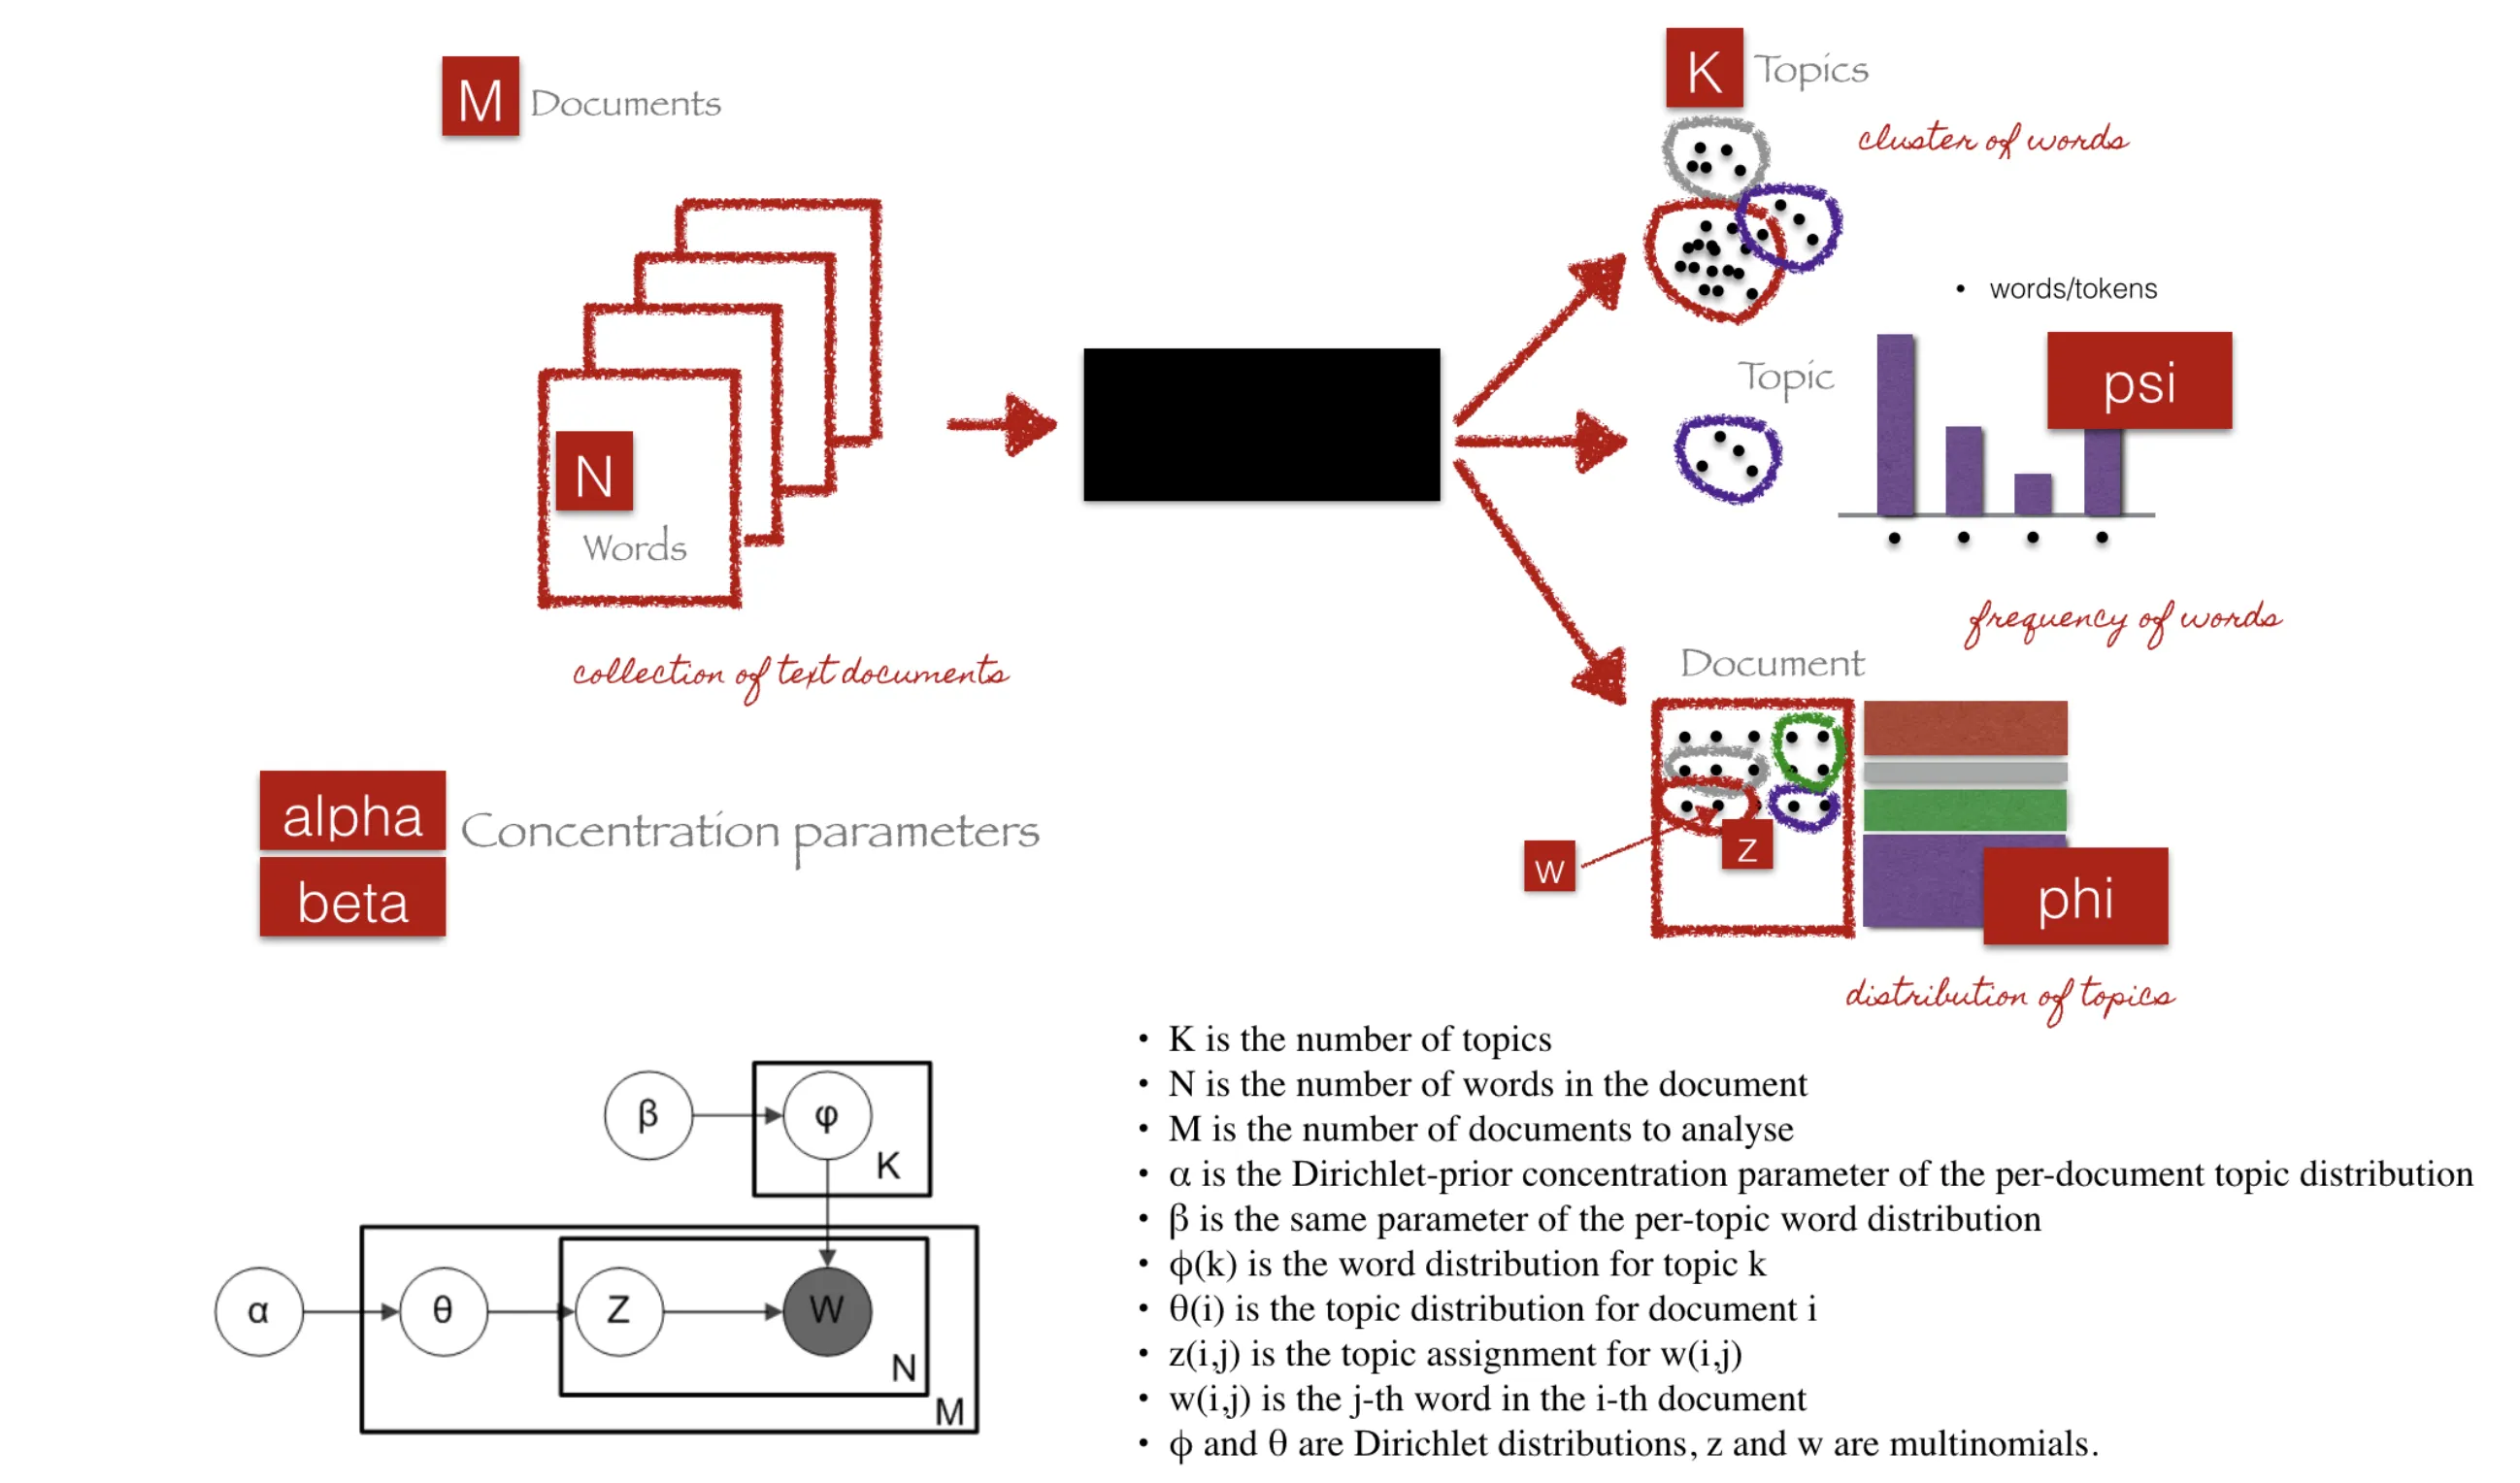

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

$\psi$ (psi) the distribution of words for each topic $K$

$\phi$ (phi) the distribution of topics for each document $i$

## Data preperation

### Reading Data from CSV

In [1]:
import pandas as pd

csv_file = "arxiv.csv"
data = pd.read_csv(csv_file, sep=";")

In [2]:
data = data.drop(columns=['ID', 'Published', 'PDF Link', 'Flesch reading ease', 'Number of words'], axis=1)
data.head()

,Title,Summary
0,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...
1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...
2,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...
3,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...
4,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...


### Text cleaning
1. Lowercasing - we convert all text to lowercase for uniformity,
2. Remove punctuation - we eliminate unnecessary punkctuation marks
3. Remove numbers - we are modelling topics from the text so numbers do not have any meaning in our case.
4. Remove stopwords - stop words are very common words that carry no meaning or less meaning compared to other words. If we remove the words that are less commonly used, we can focus on the important words instead.
6. Lemmatization - we extract the semantic root of a word (lemma) by considering the vocabulary and connections between the meanings of various words

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove punctuation, numbers and stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

In [6]:
data['processed_text'] = data.apply(lambda row: preprocess_text(row['Title'] + " " + row['Summary']), axis=1)
data.head()

,Title,Summary,processed_text
0,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,"[uniform, semantic, treatment, default, autoep..."
1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,"[accuracy, running, time, gsat, randomized, al..."
2,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,"[syntactic, autonomy, autonomy, without, symbo..."
3,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,"[consistency, management, normal, logic, progr..."
4,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,"[abductive, diagnosis, revisited, modeling, pe..."


### Exploratory Analysis

To verify whether the preprocessing, a simple word cloud is made using the wordcloud package to get a visual representation of most common words.

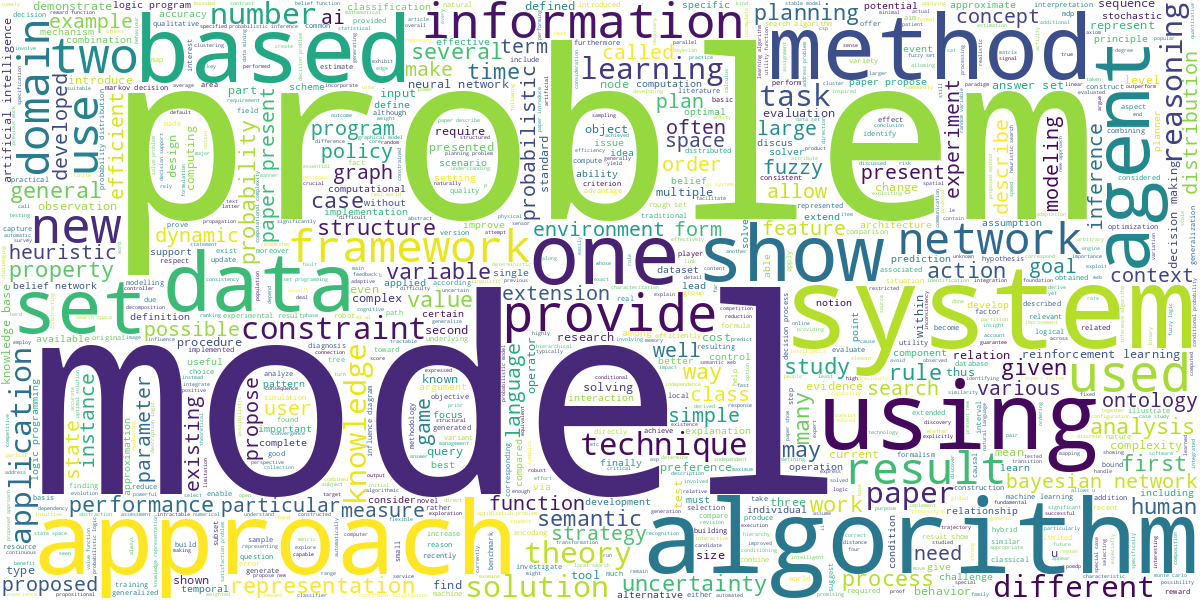

In [7]:
from wordcloud import WordCloud

long_string = ",".join([item for sublist in data['processed_text'] for item in sublist])

wordcloud = WordCloud(
    background_color="white",
    max_words=10000,
    contour_width=5,
    contour_color='steelblue',
    width=1200,
    height=600
)

wordcloud.generate(long_string)

wordcloud.to_image()

### Prepare text for LDA analysis

In [8]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data['processed_text'])
# Create Corpus
texts = data['processed_text']
# Term Document Frequency
# It converts each document (list of words) in texts into a bag-of-words (BoW) representation
corpus = [id2word.doc2bow(text) for text in texts]
# View
# If a document contains the word "data" three times and "science" once, the doc2bow output might look like [(0, 3), (1, 1)], where 0 and 1 are IDs for "data" and "science," respectively
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 6), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


### LDA - gensim

#### Model training

In [10]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.2 MB/s eta 0:00:00


In [15]:
from pprint import pprint
import gensim

# number of topics
num_topics = 70

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 70 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(44,
  '0.015*"system" + 0.009*"algorithm" + 0.008*"network" + 0.007*"change" + '
  '0.007*"show" + 0.007*"approach" + 0.007*"event" + 0.007*"time" + '
  '0.006*"problem" + 0.006*"data"'),
 (66,
  '0.013*"algorithm" + 0.009*"using" + 0.009*"model" + 0.007*"problem" + '
  '0.007*"language" + 0.007*"inference" + 0.007*"game" + 0.006*"system" + '
  '0.006*"logic" + 0.006*"method"'),
 (28,
  '0.019*"algorithm" + 0.009*"problem" + 0.009*"agent" + 0.008*"network" + '
  '0.008*"model" + 0.007*"approach" + 0.006*"distribution" + 0.005*"proposed" '
  '+ 0.005*"based" + 0.005*"using"'),
 (30,
  '0.012*"model" + 0.010*"learning" + 0.009*"task" + 0.008*"problem" + '
  '0.007*"approach" + 0.006*"paper" + 0.006*"decision" + 0.006*"method" + '
  '0.006*"domain" + 0.006*"information"'),
 (49,
  '0.010*"problem" + 0.009*"approach" + 0.009*"new" + 0.008*"model" + '
  '0.007*"based" + 0.007*"domain" + 0.007*"data" + 0.006*"knowledge" + '
  '0.006*"system" + 0.006*"paper"'),
 (26,
  '0.023*"set" + 0.011*

#### Analyzing model

In [13]:
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os

pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))

with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7     -0.005390  0.017252       1        1  4.064819
52     0.007557  0.009632       2        1  3.805685
47     0.013107 -0.009985       3        1  3.070394
38     0.003887  0.012531       4        1  3.019072
69    -0.000567  0.020642       5        1  2.813780
...         ...       ...     ...      ...       ...
29     0.005681  0.004036      66        1  0.547588
34     0.008153 -0.045705      67        1  0.480547
57    -0.084116 -0.051276      68        1  0.443899
48    -0.000784 -0.052226      69        1  0.423857
65     0.026025 -0.067697      70        1  0.405344

[70 rows x 5 columns], topic_info=           Term         Freq        Total Category  logprob  loglift
221       model  3061.000000  3061.000000  Default  30.0000  30.0000
808    learning  1945.000000  1945.000000  Default  29.0000  29.0000
990        game   803.000000   803.000000  Default  28.0000  28.0000
115     problem  3045.000000  3045.000000  Default  27.0000  27.0000
812     network  1486.000000  1486.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1607   bayesian     4.493664   550.183017  Topic70  -5.6987   0.7006
393    approach     5.125388  2120.594656  Topic70  -5.5672  -0.5171
339   inference     4.502930   779.860151  Topic70  -5.6967   0.3538
225     present     4.061513   998.358056  Topic70  -5.7998   0.0036
84    algorithm     4.168805  2770.303438  Topic70  -5.7738  -0.9909

[5377 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1115       1  0.024768        0
1115       2  0.049536        0
1115       3  0.049536        0
1115       4  0.024768        0
1115       5  0.024768        0
...      ...       ...      ...
12621     61  0.088312     zeta
12621     68  0.088312     zeta
7581      35  0.320689      zhu
13320      1  0.232332  zooming
13320     25  0.464664  zooming

[30262 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 53, 48, 39, 70, 40, 23, 51, 69, 33, 1, 22, 7, 64, 20, 47, 15, 31, 21, 52, 16, 10, 63, 14, 27, 28, 55, 50, 12, 11, 25, 62, 38, 68, 44, 37, 13, 45, 5, 2, 9, 42, 34, 36, 56, 67, 24, 3, 26, 65, 57, 59, 29, 19, 4, 60, 43, 6, 18, 32, 17, 61, 46, 54, 41, 30, 35, 58, 49, 66])

List of terms associated with a selected topic represent the most significant words within it, giving a sense of what the it is about.
Each topic shows a list of words ranked by their importance.
*   When λ is close to 1, the terms are ranked by frequency within the topic. This shows the most commonly occurring words within the topic.
*   When λ is close to 0, the terms are ranked by exclusivity, meaning they are more unique or specific to the topic.

The Intertopic Distance Plot is a two-dimensional visualization showing how different topics relate to each other within the broader document collection. Each topic is represented as a circle, with the size of the circle indicating its relative prevalence (importance or size).
The distance between circles represents the similarity or relationship between topics.

### LDA - sklearn

#### Model training, with grid search

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [55, 60, 65, 70, 75], 'learning_decay': [0.5, 0.7, 0.9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=search_params)

data_vectorized = gensim.matutils.corpus2dense(corpus, num_terms=len(id2word)).T
model.fit(data_vectorized)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [55, 60, 65, 70, 75]})

#### Analyzing model

In [24]:
!pip install hdbscan

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
!pip install umap-learn

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


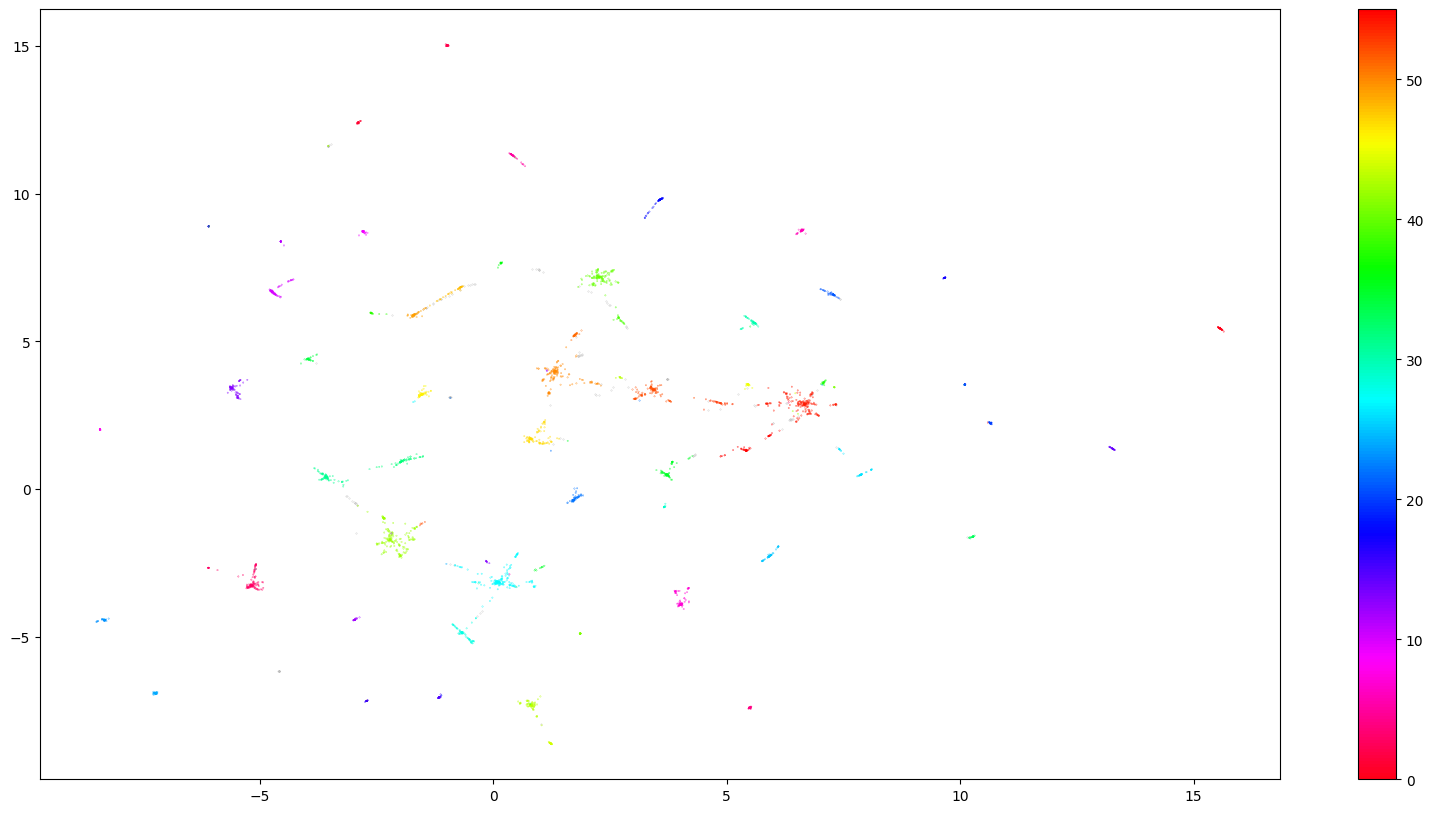

In [45]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import hdbscan

best_lda_model = model.best_estimator_
topic_distribution = best_lda_model.transform(data_vectorized)

umap_model = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine')
topic_embeddings = umap_model.fit_transform(topic_distribution)
cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(topic_embeddings)

umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(topic_distribution)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [46]:
number_of_clusters = max(set(cluster.labels_))
print(f"Number of clusters: {number_of_clusters}")

Number of clusters: 55


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
